#***VITON-pre-processing***

***In this Colab notebook, I attempted to prepare VITON pre-processing which includes human-parsing, densepose pose-estimation, and cloth mask. To achieve this, I utilized various Git repositories, which you can refer to using the following links. If you're running the code on Google Colab, you won't need to install, migrate, or troubleshoot any issues. However, if you want to run the code locally, you may need to install some dependencies. Please note that this Colab notebook is simple and the first version of the process, which will be updated in the future. For reference, you may want to visit the following links:***


*   **Dense-pose:** https://github.com/facebookresearch/detectron2
*   **Human-parse:** https://github.com/GoGoDuck912/Self-Correction-Human-Parsing
* **pose-estimation** https://github.com/CMU-Perceptual-Computing-Lab/openpose *(although in this Colab, I used a PyTorch version of OpenPose due to faster execution time)*
* **Cloth-mask:** I developed two solutions, one using OpenCV and the other using U-2-net.

❗Although I have utilized numerous git repositories, I haven't been able to devote sufficient time to cleaning the code. However, despite the lack of cleanup, the code still functions properly.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
%cd /content/drive/MyDrive/VITON-pre-processing

/content/drive/MyDrive/VITON-pre-processing


**All of the methods presented in this collaborative notebook are easy to comprehend and are specifically designed for practical usage. To utilize any of the pre-processing steps, you will need to upload your data to a folder titled 'input-folder', execute the script, and observe the outcomes in a folder named 'output-folder'.**

#Installing dependencies

In [29]:
!python -m pip install -q pyyaml==5.1
!pip install -q av
!pip install -q fvcore
!pip install -q omegaconf
!pip install -q ninja

# Cloth mask(edge)

## using-cv

In [30]:
%cd cloth-binary-mask/using-cv

/content/drive/MyDrive/VITON-pre-processing/cloth-binary-mask/using-cv


The goal of this code is to process images in an input folder by extracting the cloth regions from the images and saving them as binary mask images in an output folder using OpenCV (cv2) library in Python.

In [31]:
import cv2
import numpy as np
import os
import time

# Record the start time
start_time = time.time()

def get_cloth_mask(image_path):
    image = cv2.imread(image_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(image)

    cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)

    return mask

def process_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = os.listdir(input_folder)
    image_files = [f for f in image_files if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    for image_file in image_files:
        input_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, image_file)

        cloth_mask = get_cloth_mask(input_path)

        cv2.imwrite(output_path, cloth_mask)

        print(f"Cloth mask saved at: {output_path}")

input_folder = "input-folder"
output_folder = "output-folder"
process_images(input_folder, output_folder)
# Record the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

# Print the execution time in seconds
print("Execution time: {:.4f} seconds".format(execution_time))


Cloth mask saved at: output-folder/008320_1.jpg
Cloth mask saved at: output-folder/012187_1.jpg
Cloth mask saved at: output-folder/015044_1.jpg
Cloth mask saved at: output-folder/017039_1.jpg
Execution time: 0.0570 seconds


In [32]:
%cd ..

/content/drive/MyDrive/VITON-pre-processing/cloth-binary-mask


##using U-2-Net

In [33]:
%cd using-U-2-Net

/content/drive/MyDrive/VITON-pre-processing/cloth-binary-mask/using-U-2-Net


In [34]:
%cd unet
import u2net_load
import u2net_run
u2net = u2net_load.model(model_name = 'u2netp')
%cd ..

/content/drive/MyDrive/VITON-pre-processing/cloth-binary-mask/using-U-2-Net/unet
...load U2NEP---4.7 MB
/content/drive/MyDrive/VITON-pre-processing/cloth-binary-mask/using-U-2-Net


In [35]:
import time

# Record the start time
start_time = time.time()
u2net_run.infer(u2net, 'input-folder', 'output-folder')
# Record the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

# Print the execution time in seconds
print("Execution time: {:.4f} seconds".format(execution_time))

Generating mask for: Copie de 012187_1.jpg
Saving output at output-folder/Copie de 012187_1.jpg
Generating mask for: Copie de 017039_1.jpg
Saving output at output-folder/Copie de 017039_1.jpg
Generating mask for: Copie de 015044_1.jpg
Saving output at output-folder/Copie de 015044_1.jpg
Generating mask for: Copie de 008320_1.jpg
Saving output at output-folder/Copie de 008320_1.jpg
Execution time: 0.4704 seconds


In [36]:
%cd ..
%cd ..

/content/drive/MyDrive/VITON-pre-processing/cloth-binary-mask
/content/drive/MyDrive/VITON-pre-processing


# Dense pose


In [37]:
#!git clone https://github.com/facebookresearch/detectron2.git

In [38]:
%cd detectron2/projects/DensePose

/content/drive/MyDrive/VITON-pre-processing/detectron2/projects/DensePose


###densepose using detectron2 

In [39]:
import torch
import pickle
import numpy as np
import torch.nn.functional as F

def generate_densepose(image_path):
    # Run DensePose on the input image and generate the dump file
    !python apply_net.py dump configs/densepose_rcnn_R_101_FPN_DL_s1x.yaml model_final_844d15.pkl {image_path} --output dump.pkl -v

    # Load the DensePose output and process the labels
    with open("dump.pkl", "rb") as f:
        data = pickle.load(f)
    im = data[0]["pred_densepose"][0].labels.to("cpu")
    im = im.reshape(1, 1, im.shape[0], im.shape[1]).to(torch.float32)
    im = F.interpolate(im, (256, 192)).reshape(256, 192)
    im = im.numpy().astype(np.uint8)

    # Save the processed labels as a numpy file
    np.save("./dump.npy", im)

    # Return the processed labels as a numpy array
    return np.load("./dump.npy")

###Upload you data in your 'input-folder' also the folder of the result 'output-folder'

In [40]:
input_folder = "input-folder"
output_folder = "output-folder"

# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each image in the input folder
for image_file in os.listdir(input_folder):
    # Check if the file is an image
    if image_file.endswith(".jpg") or image_file.endswith(".jpeg") or image_file.endswith(".png"):
        # Construct the full path to the input and output files
        input_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, os.path.splitext(image_file)[0] + ".npy")

        # Generate the DensePose output for the input image
        densepose_output = generate_densepose(input_path)

        # Save the DensePose output as a numpy file in the output folder
        np.save(output_path, densepose_output)

[04/26 11:44:59 apply_net]: Loading config from configs/densepose_rcnn_R_101_FPN_DL_s1x.yaml
[04/26 11:44:59 apply_net]: Loading model from model_final_844d15.pkl
[04/26 11:45:01 apply_net]: Loading data from input-folder/005311_0.jpg
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[04/26 11:45:02 apply_net]: Processing input-folder/005311_0.jpg
[04/26 11:45:02 apply_net]: Output saved to dump.pkl
[04/26 11:45:10 apply_net]: Loading config from configs/densepose_rcnn_R_101_FPN_DL_s1x.yaml
[04/26 11:45:10 apply_net]: Loading model from model_final_844d15.pkl
[04/26 11:45:12 apply_net]: Loading data from input-folder/009416_0.jpg
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an up

###Comparing the results of the script with the pre-processed VITON dataset

**This script can be utilized to compare the densepose produced in the VITON dataset with the outcomes obtained from the script, which yield nearly identical results.**


***The result will be saved at results folder***




In [41]:
import os
import numpy as np
from PIL import Image
from skimage.color import label2rgb

input_folder = "output-folder"
output_folder = "results"

# Create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all .npy files in input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith(".npy"):
        # Load labeled image from file
        file_path = os.path.join(input_folder, file_name)
        pred = np.load(file_path)

        # Convert labeled image to RGB image
        pred = label2rgb(pred, bg_label=0)

        # Convert data type to uint8
        pred = (pred * 255).astype(np.uint8)

        # Create PIL Image object
        pil_pred = Image.fromarray(pred)

        # Save image to file
        output_path = os.path.join(output_folder, file_name[:-4] + ".png")
        pil_pred.save(output_path)


In [42]:
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive/VITON-pre-processing/detectron2/projects
/content/drive/MyDrive/VITON-pre-processing/detectron2
/content/drive/MyDrive/VITON-pre-processing


###Results

Pre-processed VITON :

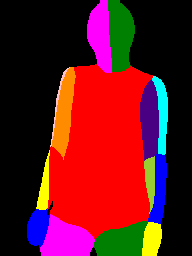

Script result:

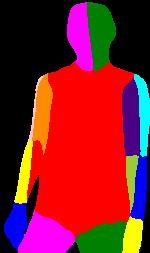

#Label

In [43]:
#git clone https://github.com/GoGoDuck912/Self-Correction-Human-Parsing.git

In [44]:
%cd Human-Parsing

/content/drive/MyDrive/VITON-pre-processing/Human-Parsing


In [45]:
import time
# Record the start time
start_time = time.time()
!python3 simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'input-folder' --output-dir 'output-folder'
# Record the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

# Print the execution time in seconds
print("Execution time: {:.4f} seconds".format(execution_time))

100% 4/4 [00:00<00:00,  5.81it/s]
Execution time: 6.9129 seconds


In [46]:
%cd ..

/content/drive/MyDrive/VITON-pre-processing


#Pose

###Open-pose for key-points generation

In [47]:
%cd Pose-map

/content/drive/MyDrive/VITON-pre-processing/Pose-map


In [48]:
from predict_pose import generate_pose_keypoints
import time
# Record the start time
start_time = time.time()
import os
from PIL import Image

input_folder = 'input-folder'
output_folder = 'output-folder'
for filename in os.listdir(input_folder):
  if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(input_folder, filename)
        img_name = os.path.splitext(filename)[0]
        pose_path = os.path.join(output_folder, img_name + '_keypoints.json')
        generate_pose_keypoints(img_path, pose_path)


# Record the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

# Print the execution time in seconds
print("Execution time: {:.4f} seconds".format(execution_time))

File saved at output-folder/000758_0_keypoints.json
File saved at output-folder/015840_0_keypoints.json
File saved at output-folder/016073_0_keypoints.json
Execution time: 16.4165 seconds


###Comparing script results with VITON-pre-processed data

**I used a straightforward approach by assigning a threshold value of 20 to each keypoint. Based on this, I obtained a threshold value of approximately 340, which I then applied to check the similarity between the two methods. I have previously employed this method in other works that required the use of OpenPose, and I achieved similar results to the desired outcome.**

In [49]:
import json

# Load the two JSON files
with open('output-folder/000758_0_keypoints.json') as f:
    data1 = json.load(f)

with open('output-folder/000758_0_keypoints (1).json') as f:#it's from the key-points of the pre-processed data
    data2 = json.load(f)

# Get the pose keypoints from each file
keypoints1 = data1['people'][0]['pose_keypoints']
keypoints2 = data2['people'][0]['pose_keypoints']

# Compare the keypoints in each file
for i in range(len(keypoints1)):
    if abs(keypoints1[i] - keypoints2[i]) > 340:   # set a threshold for the difference
        print("The two files have different pose keypoints.")
        break
else:
    print("The two files have almost the same pose keypoints.")


The two files have almost the same pose keypoints.
